In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### For GSPC Index

In [2]:
df = pd.read_csv('../data/^gspc_raw_data.csv')
df = df[['Close', 'High', 'Low', 'Open']]
df

,Close,High,Low,Open
0,^GSPC,^GSPC,^GSPC,^GSPC
1,1455.219970703125,1478.0,1438.3599853515625,1469.25
2,1399.4200439453125,1455.219970703125,1397.4300537109375,1455.219970703125
3,1402.1099853515625,1413.27001953125,1377.6800537109375,1399.4200439453125
4,1403.449951171875,1411.9000244140625,1392.0999755859375,1402.1099853515625
...,...,...,...,...
6379,5886.5498046875,5906.64013671875,5845.02001953125,5854.14990234375
6380,5892.580078125,5906.5498046875,5872.10986328125,5896.740234375
6381,5916.93017578125,5924.2099609375,5865.16015625,5869.81982421875
6382,5958.3798828125,5958.6201171875,5907.35986328125,5929.08984375


In [3]:
df = df.drop(index=[0, 1]).reset_index(drop=True)

In [4]:
df

,Close,High,Low,Open
0,1399.4200439453125,1455.219970703125,1397.4300537109375,1455.219970703125
1,1402.1099853515625,1413.27001953125,1377.6800537109375,1399.4200439453125
2,1403.449951171875,1411.9000244140625,1392.0999755859375,1402.1099853515625
3,1441.469970703125,1441.469970703125,1400.72998046875,1403.449951171875
4,1457.5999755859375,1464.3599853515625,1441.469970703125,1441.469970703125
...,...,...,...,...
6377,5886.5498046875,5906.64013671875,5845.02001953125,5854.14990234375
6378,5892.580078125,5906.5498046875,5872.10986328125,5896.740234375
6379,5916.93017578125,5924.2099609375,5865.16015625,5869.81982421875
6380,5958.3798828125,5958.6201171875,5907.35986328125,5929.08984375


In [5]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

In [6]:
seq_length = 20
num_features = 4
X,y = create_sequence(df, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5105, 20, 4) (1257, 20, 4) (5105,) (1257,)


In [7]:
scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.transform(y_test.reshape(-1,1))

In [8]:
x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5105, 20, 4]) torch.Size([1257, 20, 4]) torch.Size([5105, 1]) torch.Size([1257, 1])


#define model

In [9]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUmodel, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])
    return out

In [10]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [11]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = GRUmodel(input_size = num_features, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model

In [12]:
best_mse = float('inf')
best_params = {}
neurons = [200,500,1000]
optimizers = ['adam', 'sgd']

for n in neurons:
  for opt in optimizers:
    mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
    print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
    if mse < best_mse:
      best_mse = mse
      best_params = {'neurons': n, 'optimizer': opt}
      best_model = model

Epoch [1/10], Loss: 0.0940
Epoch [1/10], Loss: 0.0541
Epoch [1/10], Loss: 0.0070
Epoch [1/10], Loss: 0.0275
Epoch [1/10], Loss: 0.0199
Epoch [1/10], Loss: 0.0041
Epoch [1/10], Loss: 0.0015
Epoch [1/10], Loss: 0.0104
Epoch [1/10], Loss: 0.0045
Epoch [1/10], Loss: 0.0029
Epoch [1/10], Loss: 0.0006
Epoch [1/10], Loss: 0.0033
Epoch [1/10], Loss: 0.0035
Epoch [1/10], Loss: 0.0011
Epoch [1/10], Loss: 0.0006
Epoch [1/10], Loss: 0.0011
Epoch [1/10], Loss: 0.0003
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0022
Epoch [1/10], Loss: 0.0079
Epoch [1/10], Loss: 0.0048
Epoch [1/10], Loss: 0.0046
Epoch [1/10], Loss: 0.0005
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0036
Epoch [1/10], Loss: 0.0067
Epoch [1/10], Loss: 0.0059
Epoch [1/10], Loss: 0.0060
Epoch [1/10], Loss: 0.0046
Epoch [1/10], Loss: 0.0038
Epoch [1/10], Loss: 0.0029
Epoch [1/10], Loss: 0.0005
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0015
E

Best MSE: 0.002276261569932103
Best Params: {'neurons': 1000, 'optimizer': 'sgd'}
MSE: 0.002276261569932103


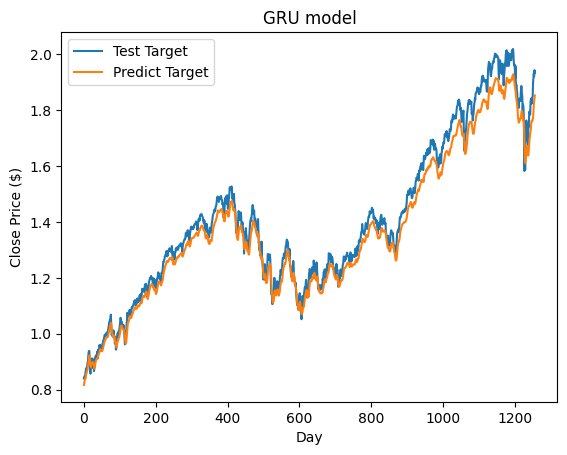

In [13]:

print(f'Best MSE: {best_mse}')
print(f'Best Params: {best_params}')

# Dự đoán và vẽ đồ thị
best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
print(f'MSE: {mse}')

plt.title("GRU model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test.numpy(), label="Test Target")
plt.plot(y_pred.numpy(), label="Predict Target")
plt.legend()
plt.show()

In [14]:
# Save model
torch.save(best_model.state_dict(), 'GSPC_gru_regression.pth')

### For IBM Stock

In [15]:
df_ibm = pd.read_csv('../data/ibm_raw_data.csv')
df_ibm = df_ibm[['Close', 'High', 'Low', 'Open']]
df_ibm = df_ibm.drop(index=[0, 1]).reset_index(drop=True)

In [16]:
df_ibm

,Close,High,Low,Open
0,107.13432312011719,109.46463012695312,105.9990463256836,108.98661804199219
1,110.8986587524414,114.48374938964844,107.19407653808594,107.97084045410156
2,108.98661804199219,113.70697784423828,108.50860595703125,112.81070709228516
3,108.50860595703125,112.7509536743164,105.76004028320312,112.09368896484375
4,112.81070709228516,114.12523651123047,110.3011474609375,112.09368896484375
...,...,...,...,...
6378,257.82000732421875,260.54998779296875,256.2200012207031,257.6000061035156
6379,266.67999267578125,267.42999267578125,258.6099853515625,259.010009765625
6380,266.760009765625,267.9800109863281,264.5899963378906,266.3500061035156
6381,268.4100036621094,269.1400146484375,265.0799865722656,265.45001220703125


In [17]:
X,y = create_sequence(df_ibm, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5105, 20, 4) (1258, 20, 4) (5105,) (1258,)


In [18]:
scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.transform(y_test.reshape(-1,1))

In [19]:
x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5105, 20, 4]) torch.Size([1258, 20, 4]) torch.Size([5105, 1]) torch.Size([1258, 1])


In [20]:
best_mse = float('inf')
best_params = {}
neurons = [200,500,1000]
optimizers = ['adam', 'sgd']

for n in neurons:
  for opt in optimizers:
    mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
    print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
    if mse < best_mse:
      best_mse = mse
      best_params = {'neurons': n, 'optimizer': opt}
      best_model = model

Epoch [1/10], Loss: 0.1920
Epoch [1/10], Loss: 0.0449
Epoch [1/10], Loss: 0.0290
Epoch [1/10], Loss: 0.0440
Epoch [1/10], Loss: 0.0389
Epoch [1/10], Loss: 0.0050
Epoch [1/10], Loss: 0.0328
Epoch [1/10], Loss: 0.0272
Epoch [1/10], Loss: 0.0004
Epoch [1/10], Loss: 0.0012
Epoch [1/10], Loss: 0.0205
Epoch [1/10], Loss: 0.0223
Epoch [1/10], Loss: 0.0042
Epoch [1/10], Loss: 0.0017
Epoch [1/10], Loss: 0.0017
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0016
Epoch [1/10], Loss: 0.0041
Epoch [1/10], Loss: 0.0089
Epoch [1/10], Loss: 0.0076
Epoch [1/10], Loss: 0.0063
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0011
Epoch [1/10], Loss: 0.0065
Epoch [1/10], Loss: 0.0090
Epoch [1/10], Loss: 0.0058
Epoch [1/10], Loss: 0.0066
Epoch [1/10], Loss: 0.0073
Epoch [1/10], Loss: 0.0031
Epoch [1/10], Loss: 0.0005
Epoch [1/10], Loss: 0.0009
Epoch [1/10], Loss: 0.0000
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0017
Epoch [1/10], Loss: 0.0036
Epoch [1/10], Loss: 0.0034
E

Best MSE: 0.0016599444206804037
Best Params: {'neurons': 500, 'optimizer': 'adam'}
MSE: 0.0016599444206804037


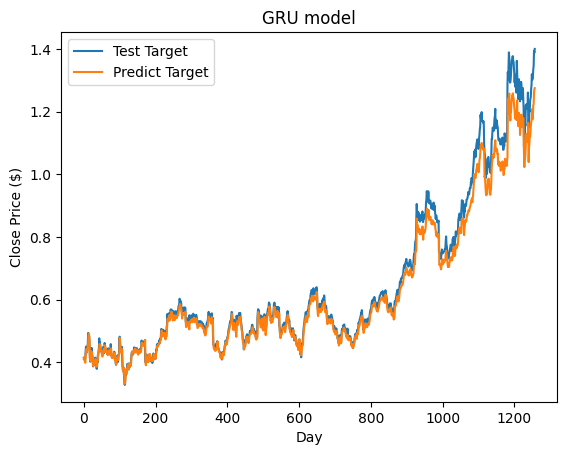

In [21]:

print(f'Best MSE: {best_mse}')
print(f'Best Params: {best_params}')

# Dự đoán và vẽ đồ thị
best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
print(f'MSE: {mse}')

plt.title("GRU model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test.numpy(), label="Test Target")
plt.plot(y_pred.numpy(), label="Predict Target")
plt.legend()
plt.show()

In [22]:
# Save model
torch.save(best_model.state_dict(), 'IBM_gru_regression.pth')